# Sentiment-Analysis-For-Customer-Reviews

_Note: As the dataset is huge, Colab GPU was used for training. This notebook is colab compatible._

In [39]:
!nvidia-smi # Checking GPU status

Thu Jul  2 15:09:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   8827MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import os
import datetime
import tensorflow_datasets as tfds

In [3]:
import pkg_resources

In [5]:
print(tf.__version__)

2.2.0


In [6]:
tf.config.experimental.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# Downloading and loading the dataset.
dataset, info = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', with_info=True)
train_dataset = dataset['train']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incompleteVQ7RQ9/amazon_us_reviews-train.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.


In [8]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

In [9]:
print(train_dataset)

<DatasetV1Adapter shapes: {data: {customer_id: (), helpful_votes: (), marketplace: (), product_category: (), product_id: (), product_parent: (), product_title: (), review_body: (), review_date: (), review_headline: (), review_id: (), star_rating: (), total_votes: (), verified_purchase: (), vine: ()}}, types: {data: {customer_id: tf.string, helpful_votes: tf.int32, marketplace: tf.string, product_category: tf.string, product_id: tf.string, product_parent: tf.string, product_title: tf.string, review_body: tf.string, review_date: tf.string, review_headline: tf.string, review_id: tf.string, star_rating: tf.int32, total_votes: tf.int32, verified_purchase: tf.int64, vine: tf.int64}}>


In [10]:
len(list(train_dataset))

104975

In [11]:
BUFFER_SIZE = 30000 # How much data you want to prefatch
BATCH_SIZE = 128

In [12]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False) # Shuffling train data.

for reviews in train_dataset.take(2):
    print(reviews)

{'data': {'customer_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2048863'>, 'helpful_votes': <tf.Tensor: shape=(), dtype=int32, numpy=1>, 'marketplace': <tf.Tensor: shape=(), dtype=string, numpy=b'US'>, 'product_category': <tf.Tensor: shape=(), dtype=string, numpy=b'Mobile_Electronics'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B00HLV63IO'>, 'product_parent': <tf.Tensor: shape=(), dtype=string, numpy=b'538701671'>, 'product_title': <tf.Tensor: shape=(), dtype=string, numpy=b'BLUE Clip-Dat Mini Clip MP3 Player - Same Day Processing w/ USPS First-Class'>, 'review_body': <tf.Tensor: shape=(), dtype=string, numpy=b"Mp3 player came in today a week in advance than I was told it would arrive.<br /><br />and it feels incredible for the price. I only paid 0.50+$3.00 shipping and this mp3 player feels like a $15+ product.<br /><br />**A WARNING HOWEVER**<br /><br />- Although its a fantastic mp3 player this does not come with any cables or memory cards. You'll need to buy a 

In [13]:
# Printing Sample Reviews.
for reviews in train_dataset.take(10):
    review_text = reviews['data']
    print(review_text.get('review_body').numpy())
    print(review_text.get('star_rating'))
    print(tf.where(review_text.get('star_rating')>3,1,0).numpy())

b"Mp3 player came in today a week in advance than I was told it would arrive.<br /><br />and it feels incredible for the price. I only paid 0.50+$3.00 shipping and this mp3 player feels like a $15+ product.<br /><br />**A WARNING HOWEVER**<br /><br />- Although its a fantastic mp3 player this does not come with any cables or memory cards. You'll need to buy a microSD card (OPTIONAL : and a miniusb cable) depending on what you prefer you will need either a microSD to USB adapter or miniusb cable."
tf.Tensor(4, shape=(), dtype=int32)
1
b'These earpieces are heavy duty and worked great, even in crowd noise!'
tf.Tensor(5, shape=(), dtype=int32)
1
b'Was a little hard to get both paired up in stereo mode but eventually got it to work and the work great. Nice little speakers I can take anywhere!'
tf.Tensor(4, shape=(), dtype=int32)
1
b'the cover is cute but it broke within 2 days ..hey i guess thats what for paying including shipping $3'
tf.Tensor(2, shape=(), dtype=int32)
0
b'The device prov

In [14]:
tokenizer = tfds.features.text.Tokenizer()

In [15]:
# Generating vocabulary set.
vocabulary_set = set()

for _, reviews in train_dataset.enumerate():
    review_text = reviews['data']
    reviews_tokens = tokenizer.tokenize(review_text.get('review_body').numpy())
    vocabulary_set.update(reviews_tokens)

In [16]:
vocab_size = len(vocabulary_set)
vocab_size

73738

In [17]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

print(vocabulary_set)

{'sprinkled', '175W', 'lwhat', 'Extended', 'nominated', 'crashing', 'JBLS', 'looved', '180meg', 'lotus', 'gunna', 'usado', 'Autobar', 'Solemate', 'mornings', 'DAS', 'backround', 'CEN', 'stripling', 'PDAirs', 'remidied', 'trees', 'earphone', 'Wouxun', 'blinged', 'purfect', 'JawBone', 'Consumers', 'stollen', 'sounds', 'critiques', 'SUPERB', 'XD', 'innovador', 'narrating', 'overtaken', 'Plainly', 'knotches', 'boardwalk', 'Stabilized', 'thiss', 'Rustolium', 'DISAPPOINT', 'INCIDENT', 'fussiness', 'eyeing', 'HEADPHONEs', 'Ek', 'sneer', 'toying', 'biger', 'unattractive', 'FD', '2315', 'adroidified', 'Velco', 'imaginable', 'smartcover', 'thresholds', 'picket', 'PRENDIDO', 'lvl', 'complian', '4min', 'fieldbox', 'middling', 'corvette', 'discreteness', 'wowzers', 'iPAQ', 'flypaper', 'suelte', 'anybody', 'doorstep', 'transverter', 'FlipUltra', 'empire', 'actaul', 'retailing', 'wasd', 'Consulting', 'screenings', 'protecter', 'higgs', 'cursory', '3000watt', 'thinner', 'field', 'lysol', 'tacky', 'Pra

In [18]:
# Sample encoding. 
for reviews in train_dataset.take(5):
    review_text = reviews['data']
    print(review_text.get('review_body').numpy())
    encoded_example = encoder.encode(review_text.get('review_body').numpy())
    print(encoded_example)

b"Mp3 player came in today a week in advance than I was told it would arrive.<br /><br />and it feels incredible for the price. I only paid 0.50+$3.00 shipping and this mp3 player feels like a $15+ product.<br /><br />**A WARNING HOWEVER**<br /><br />- Although its a fantastic mp3 player this does not come with any cables or memory cards. You'll need to buy a microSD card (OPTIONAL : and a miniusb cable) depending on what you prefer you will need either a microSD to USB adapter or miniusb cable."
[14337, 21818, 71233, 46830, 52300, 61963, 26233, 46830, 9463, 18873, 11153, 54162, 42292, 363, 28564, 56708, 41397, 41397, 30710, 363, 28654, 66031, 43693, 58133, 48252, 11153, 23132, 25971, 57183, 29140, 49187, 47665, 441, 30710, 44004, 39928, 21818, 28654, 53193, 61963, 6455, 54262, 41397, 41397, 32155, 14660, 3915, 41397, 41397, 50428, 30294, 61963, 36014, 39928, 21818, 44004, 53420, 35667, 7452, 9318, 61914, 59641, 8218, 67255, 62891, 22470, 64524, 15828, 4373, 1439, 61963, 47110, 55611, 

In [19]:
for index in encoded_example:
    print('{} ----> {}'.format(index, encoder.decode([index])))

43453 ----> The
72485 ----> device
62328 ----> provides
33253 ----> accurate
30710 ----> and
39470 ----> concise
33099 ----> information
46435 ----> about
65465 ----> my
72369 ----> vehicle
41903 ----> It
62328 ----> provides
62773 ----> feedback
46830 ----> in
58133 ----> the
72369 ----> vehicle
49356 ----> while
48370 ----> driving
30710 ----> and
58133 ----> the
17392 ----> web
29580 ----> site
17849 ----> shows
65635 ----> where
65465 ----> my
72369 ----> vehicle
66050 ----> has
9506 ----> been
30710 ----> and
12816 ----> how
363 ----> it
54162 ----> was
28265 ----> driven


In [20]:
def encode(text_tensor, label_tensor):
    encoded_text = encoder.encode(text_tensor.numpy())
    label = tf.where(label_tensor>3,1,0)
    return encoded_text, label

def encode_map_fn(tensor):

    text = tensor['data'].get('review_body')
    label = tensor['data'].get('star_rating')

    encoded_text, label = tf.py_function(encode, inp=[text,label], Tout=(tf.int64, tf.int32))

    encoded_text.set_shape([None])
    label.set_shape([])

    return encoded_text, label

In [21]:
ar_encoded_data = train_dataset.map(encode_map_fn)

for f0, f1 in ar_encoded_data.take(2):
    print(f0)
    print(f1)

tf.Tensor(
[14337 21818 71233 46830 52300 61963 26233 46830  9463 18873 11153 54162
 42292   363 28564 56708 41397 41397 30710   363 28654 66031 43693 58133
 48252 11153 23132 25971 57183 29140 49187 47665   441 30710 44004 39928
 21818 28654 53193 61963  6455 54262 41397 41397 32155 14660  3915 41397
 41397 50428 30294 61963 36014 39928 21818 44004 53420 35667  7452  9318
 61914 59641  8218 67255 62891 22470 64524 15828  4373  1439 61963 47110
 55611 26683 30710 61963 65596  7285 49773 68076 65529 12486  8765 12486
 46999 15828 67222 61963 47110  4373 51197 61872  8218 65596  7285], shape=(95,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor([14031 16327  1792 35920 26785 30710 10621 51877 42882 46830  9316 66161], shape=(12,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)


In [22]:
TAKE_SIZE = 10000

train_data = ar_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE)

test_data = ar_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

In [23]:
vocab_size += 1

sample_text, sample_labels = next(iter(test_data))
sample_text[0], sample_labels[0]

(<tf.Tensor: shape=(1000,), dtype=int64, numpy=
 array([14337, 21818, 71233, 46830, 52300, 61963, 26233, 46830,  9463,
        18873, 11153, 54162, 42292,   363, 28564, 56708, 41397, 41397,
        30710,   363, 28654, 66031, 43693, 58133, 48252, 11153, 23132,
        25971, 57183, 29140, 49187, 47665,   441, 30710, 44004, 39928,
        21818, 28654, 53193, 61963,  6455, 54262, 41397, 41397, 32155,
        14660,  3915, 41397, 41397, 50428, 30294, 61963, 36014, 39928,
        21818, 44004, 53420, 35667,  7452,  9318, 61914, 59641,  8218,
        67255, 62891, 22470, 64524, 15828,  4373,  1439, 61963, 47110,
        55611, 26683, 30710, 61963, 65596,  7285, 49773, 68076, 65529,
        12486,  8765, 12486, 46999, 15828, 67222, 61963, 47110,  4373,
        51197, 61872,  8218, 65596,  7285,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [24]:
for f0, f1 in test_data.take(10):
    print(tf.unique_with_counts(f1)[2].numpy())

[85 43]
[92 36]
[41 87]
[46 82]
[86 42]
[40 88]
[92 36]
[55 73]
[49 79]
[84 44]


In [25]:
# Simple Bidirectional LSTM model:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,128)) # We can use GloveVec as well.
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
#model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
for units in [64, 64]:
    model.add(tf.keras.layers.Dense(units,activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [26]:
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="/tmp/sentiment_analysis.hdf5",verbose=1, save_best_only=True)

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy']
)

In [27]:
history = model.fit(train_data, epochs=4, validation_data=test_data, callbacks=[tensorboard_callback, checkpointer])

Epoch 1/4
742/742 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8493
Epoch 00001: val_loss improved from inf to 0.29439, saving model to /tmp/sentiment_analysis.hdf5
742/742 [==============================] - 271s 365ms/step - loss: 0.3374 - accuracy: 0.8493 - val_loss: 0.2944 - val_accuracy: 0.8760
Epoch 2/4
742/742 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.9026
Epoch 00002: val_loss improved from 0.29439 to 0.28648, saving model to /tmp/sentiment_analysis.hdf5
742/742 [==============================] - 270s 363ms/step - loss: 0.2382 - accuracy: 0.9026 - val_loss: 0.2865 - val_accuracy: 0.8664
Epoch 3/4
742/742 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9244
Epoch 00003: val_loss did not improve from 0.28648
742/742 [==============================] - 262s 353ms/step - loss: 0.1885 - accuracy: 0.9244 - val_loss: 0.3054 - val_accuracy: 0.8877
Epoch 4/4
742/742 [==============================] - ETA: 0s 

In [28]:
model.save('/tmp/final_sentiment_analysis.hdf5')

In [29]:
eval_loss, eval_acc = model.evaluate(test_data)
print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))

79/79 [==============================] - 13s 169ms/step - loss: 0.3011 - accuracy: 0.8844

Eval loss: 0.301, Eval accuracy: 0.884


In [30]:
for f0,f1 in test_data.take(1):
    print(f1)
    print(model.predict(f0))

tf.Tensor(
[1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0
 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1
 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1
 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1], shape=(128,), dtype=int32)
[[ 0.6283799 ]
 [ 5.2691083 ]
 [ 4.441783  ]
 [-4.8973336 ]
 [ 5.451226  ]
 [ 2.039919  ]
 [ 6.6469216 ]
 [ 6.9658184 ]
 [ 0.3844174 ]
 [ 2.978959  ]
 [ 4.5818987 ]
 [-3.5524526 ]
 [ 2.8157573 ]
 [-3.9081442 ]
 [ 0.44401163]
 [ 0.57160324]
 [ 3.2935908 ]
 [ 3.7639716 ]
 [ 6.709375  ]
 [ 7.1806827 ]
 [-1.8959455 ]
 [ 3.2224271 ]
 [ 6.789193  ]
 [ 5.258604  ]
 [ 1.3799025 ]
 [-0.07704847]
 [ 0.31462455]
 [-0.38356197]
 [-0.1554097 ]
 [ 5.6595497 ]
 [ 6.6730623 ]
 [ 6.407183  ]
 [ 4.382217  ]
 [-4.063348  ]
 [ 6.293059  ]
 [-1.4913331 ]
 [-4.968193  ]
 [-0.7250801 ]
 [-1.6417805 ]
 [ 1.727544  ]
 [ 2.8275936 ]
 [ 7.1888423 ]
 [ 6.747887  ]
 [ 6.2324305 ]
 [ 2.5622823 ]
 [ 6.342979  ]
 [ 5.4229 

In [31]:
model.layers

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         9438592   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,878,593
Trainable params: 9,878,593
Non-trainable params: 0
______________________________________________

In [34]:
!nvidia-smi


Thu Jul  2 15:03:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    32W /  70W |   8827MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

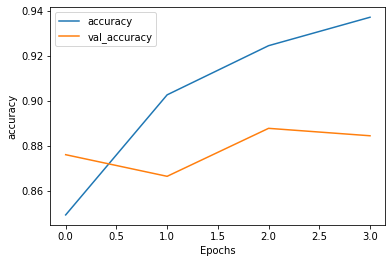

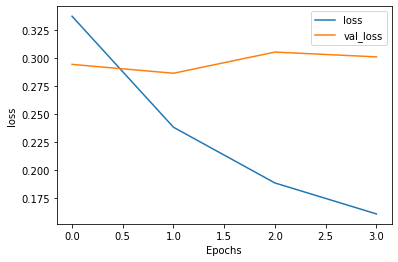

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric],'')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [36]:
tf.keras.backend.clear_session()
sa_load = tf.keras.models.load_model('/tmp/sentiment_analysis.hdf5', compile=False)

In [37]:
# Functions to be used during inference in Flask app.
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

def predict_fn(pred_text):
    encoded_pred_text = encoder.encode(pred_text)
    print(encoded_pred_text)
    encoded_pred_text = pad_to_size(encoded_pred_text,32)
    print(encoded_pred_text)
    encoded_pred_text = tf.cast(encoded_pred_text, tf.float32)
    predictions = sa_load.predict(tf.expand_dims(encoded_pred_text, 0))

    return (predictions)

In [38]:
pred_text = ('This watch is pretty bad. Color and dial looks pathetic.')
predictions = predict_fn(pred_text)
print(predictions)

[69952, 15707, 17777, 31076, 61641, 60828, 30710, 28778, 55238, 37595]
[69952, 15707, 17777, 31076, 61641, 60828, 30710, 28778, 55238, 37595, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[-1.2407379]]
